In [1]:
import numpy as np 
from scipy.optimize import rosen, shgo
from scipy.interpolate import LinearNDInterpolator
from tqdm.notebook import trange, tqdm
from scipy.optimize import basinhopping
from skimage.feature import match_template
from sklearn.metrics import mean_squared_error
from scipy.ndimage.interpolation import shift
from sklearn.metrics import mutual_info_score
import scipy
import random
from numpy import linalg as LA
import imageio
from PIL import ImageChops
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import scipy.spatial.distance as dist
from numpy import asarray
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
from scipy.ndimage.interpolation import shift
from skimage import data, img_as_float
from scipy.optimize import differential_evolution
from sklearn import preprocessing
import scipy.ndimage as snd
import h5py
import sklearn.feature_selection as sk
from sklearn.feature_selection import mutual_info_classif as MIC
import time
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imshow, imread
from skimage.color import rgb2gray
from skimage import img_as_ubyte, img_as_float
from skimage.exposure import histogram, cumulative_distribution
from scipy.optimize import fmin_powell
from scipy.optimize import dual_annealing
# plt.rcParams['image.cmap'] = 'gray'
#plt.rcParams['image.interpolation'] = 'nearest'
np.set_printoptions(precision=5,suppress=True)
import os
cwd = os.getcwd()
print(cwd)

C:\Users\bjqb7h


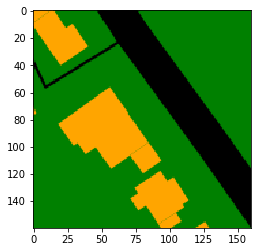

In [24]:
path_Semseg = 'C:/Users/bjqb7h/Downloads/Thesis2022/SEMSEGGPS'
log  = '/AtCityBMW_Applanix-20220601T115459Z469'
semsegpath ='C:/Users/bjqb7h/Downloads/Thesis2022/semsegimage'
path_GPS = 'C:/Users/bjqb7h/Downloads/Thesis2022/NUMPY/New/'
log_GPS  = 'AtCityBMW_Applanix-20220601T115459Z469GPSWNS1600001'
log_DGPS = 'AtCityBMW_Applanix-20220601T115459Z469DGPSWNS411'
NewSemseg ='C:/Users/bjqb7h/Downloads/Thesis2022/Semseg Images'


GPS = h5py.File(path_GPS+log_GPS+'.hdf5','r')
GPSDSET = GPS.get(log+'/Image data')
plt.imshow(GPSDSET[0])

In [25]:
h5f = h5py.File(path_Semseg +log+'.h5','r')
dset = h5f.get('grid_prediction')

#Importing DGPS MAPS
h5fDGPS = h5py.File(path_GPS+log_DGPS+'.hdf5','r')
dset5 = h5fDGPS.get(log+'/Image data')

A=len(dset5)
SemsegData = np.reshape(dset,(A,160,160,2))

print(GPSDSET.shape)

NewSemseg= h5py.File(NewSemseg+log+'Semseg'+'.hdf5','r')
NSem= NewSemseg.get(log+'/Image data')
print(NSem.shape)
print(GPSDSET.shape)


(2093, 160, 160, 4)
(2093, 160, 160, 3)
(2093, 160, 160, 4)


-4.002971280163452 -5.9837789895200855 -0.0
Frame 792


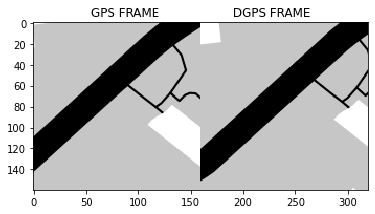

In [108]:
P=random.randint(0,2093)

#USING GPS HDF5 dATASET
t1_slice = GPSDSET[P,:,:,1]
t1_slice = np.flip(t1_slice, axis=1)
GPS_data = t1_slice



# #DGPS values
t3_slice = dset5[P,:,:,1]
t3_slice = np.flip(t3_slice, axis=1)
DGPS_data = t3_slice


# GPS_data = GPS_data/GPS_data.max()
# #OLDSEMSEG = OLDSEMSEG/OLDSEMSEG.max()
# DGPS_data=DGPS_data/DGPS_data.max()
# GPS_data = GPS_data/GPS_data.max()



plt.imshow(np.hstack((GPS_data,DGPS_data)))
plt.title("GPS FRAME                   DGPS FRAME")


dx2,dy2,MI=main_mi_reg(GPS_data,DGPS_data)
print(dx2,dy2,MI)
print("Frame",P)

In [109]:

print("The resultant dx and dy translations from image registrations are ",dx2,dy2)

print("The TRUE GT dx and dy translations  are ",dx_gt[P],dy_gt[P])

The resultant dx and dy translations from image registrations are  -4.002971280163452 -5.9837789895200855
The TRUE GT dx and dy translations  are  1.8726572014098066 -0.2661675417700029


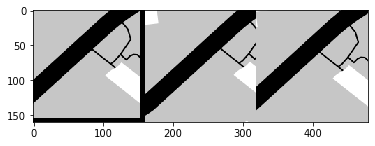

In [115]:
shifted = shift(GPS_data,(dx2,dy2))
plt.imshow(np.hstack((shifted,DGPS_data,GPS_data)))

In [116]:
from scipy import optimize
from scipy.optimize import fmin
from scipy.signal import correlate2d
from scipy.signal import correlate
from scipy.ndimage import interpolation
from sklearn.metrics import mutual_info_score

BOUNDS = [(-10,10), (-10,10)]  # Bounds (in pixels) supported by mutual information based correlator


# #Bayes theorem
def __mutual_information(ref_image_crop, cmp_image, bins=216, normed=False):
    """
    :param ref_image_crop: ndarray, cropped image from the center of reference image, needs to be same size as `cmp_image`
    :param cmp_image: ndarray, comparison image data data
    :param bins: number of histogram bins
    :param normed: return normalized mutual information
    :return: mutual information values
    """
    #use linspace instead of bins
    joint_hist,_,_ = np.histogram2d(ref_image_crop.ravel(), cmp_image.flatten(), bins=bins, range=[(0,1),(0,1)])
    ref_hist = joint_hist.sum(axis=1)
    cmp_hist = joint_hist.sum(axis=0)
    joint_ent = __entropy(joint_hist)
    ref_ent = __entropy(ref_hist)
    cmp_ent = __entropy(cmp_hist)
    mutual_info = ref_ent + cmp_ent - joint_ent
    
    if normed:
        mutual_info = mutual_info / np.sqrt(ref_ent * cmp_ent)
    return mutual_info

def obj_func(dx_dy, ref_image, cmp_image):
    dx,dy=dx_dy
    shifted_img = shift(ref_image,(dx,dy))
    Z= __mutual_information(shifted_img, cmp_image)
    return Z


def main_mi_reg(ref_image, cmp_image,bounds=BOUNDS):
    """
    Correlator based onMutual Information Algorithm
    :param ref_image: ndarray, containing reference image data
    :param cmp_image: ndarray, containing comparison image data
    :param bounds: sequence, bounds paramater in scipy.optimize.differential_evolution
    :return: (residual in X, residual in Y, match height)
    """

#     x0 = [0,0] # initial values for x and y translation
#     opt_res = fmin(obj_func, x0, args=(ref_image, cmp_image),disp=True,xtol=1e-6,maxiter=500)
#     dx, dy = opt_res[0], opt_res[1]
#     return dx, dy
#sampling_method='sobol'
#opt_res=shgo(obj_func, bounds, args=(ref_image, cmp_image),n=64, iters=4)
    opt_res = differential_evolution(obj_func, bounds, args=(ref_image, cmp_image), init="sobol",strategy = 'rand1bin',x0=[0,0],updating='deferred')
    x_best = -opt_res.x
    MI=-opt_res.fun
    dx = x_best[0]
    dy = x_best[1]
    return dx,dy,MI


def __entropy(img_hist):
    """
    :param img_hist: Array containing image histogram
    :return: image entropy
    """
    img_hist = img_hist / float(np.sum(img_hist))
    img_hist = img_hist[np.nonzero(img_hist)]
    return -np.sum(img_hist * np.log2(img_hist))


def fancy_xy_trans_slice(img_slice, x_y_trans):
    """ Return copy of `img_slice` translated by `x_y_trans` voxels
    Parameters
     ----------
     img_slice : array shape (M, N)
         2D image to transform with translation `x_vox_trans`
     x_y_trans : float
         Number of pixels (voxels) to translate `img_slice`; can be
         positive or negative, and does not need to be integer value.
     """
    # Resample image using bilinear interpolation (order=1)
    x_y_trans = np.array(x_y_trans)
    trans_slice = snd.affine_transform(img_slice, [1, 1],-x_y_trans, order=1)
    return trans_slice

dx_gt = np.load(f'C:\\Users\\bjqb7h\\Downloads\\Thesis2022\\GT TRANSLATIONS\\dxT.npy')
dy_gt = np.load(f'C:\\Users\\bjqb7h\\Downloads\\Thesis2022\\GT TRANSLATIONS\\dyT.npy')

print(dx_gt.shape)

(2093,)


In [182]:
for T in trange(2093):
    t3_slice = dset5[T,:,:,1]
    t3_slice = np.flip(t3_slice, axis=1)
    DGPS_data = t3_slice
    DGPS_data=DGPS_data/DGPS_data.max()
    shifted_image = shift(DGPS_data,(-dx_gt[T],-dy_gt[T]))
    dx,dy=main_mi_reg(shifted_image,DGPS_data)
    dx1[T,:]=dx
    dy1[T,:]=dy
    MI1[T,:]=MI
  

  0%|          | 0/2093 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: -0.534597
         Iterations: 16
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: -0.490011
         Iterations: 15
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: -0.567027
         Iterations: 18
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: -0.578982
         Iterations: 40
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.567409
         Iterations: 13
         Function evaluations: 37
Optimization terminated successfully.
         Current function value: -0.499478
         Iterations: 49
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -0.540289
         Iterations: 21
         Function evaluations: 51
Optimization terminated s

Optimization terminated successfully.
         Current function value: -0.618534
         Iterations: 48
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -0.397050
         Iterations: 24
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: -0.600713
         Iterations: 22
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: -0.299285
         Iterations: 53
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: -0.531835
         Iterations: 53
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: -0.653871
         Iterations: 50
         Function evaluations: 181
Optimization terminated successfully.
         Current function value: -0.559935
         Iterations: 47
         Function evaluations: 157
Optimization terminate

Optimization terminated successfully.
         Current function value: -0.571049
         Iterations: 36
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.532631
         Iterations: 49
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: -0.503247
         Iterations: 19
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: -0.391261
         Iterations: 49
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -0.535607
         Iterations: 15
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: -0.654762
         Iterations: 44
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: -0.358702
         Iterations: 19
         Function evaluations: 50
Optimization terminated

Optimization terminated successfully.
         Current function value: -0.687979
         Iterations: 50
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -0.466758
         Iterations: 22
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -0.415728
         Iterations: 27
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: -0.610636
         Iterations: 45
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: -0.573177
         Iterations: 22
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: -0.262749
         Iterations: 41
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -0.428538
         Iterations: 25
         Function evaluations: 82
Optimization terminated 

Optimization terminated successfully.
         Current function value: -0.348548
         Iterations: 22
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: -0.327513
         Iterations: 20
         Function evaluations: 51
Optimization terminated successfully.
         Current function value: -0.647085
         Iterations: 42
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -0.594138
         Iterations: 41
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: -0.487109
         Iterations: 53
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: -0.545621
         Iterations: 40
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -0.498396
         Iterations: 43
         Function evaluations: 140
Optimization terminate

Optimization terminated successfully.
         Current function value: -0.625000
         Iterations: 51
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: -0.416244
         Iterations: 26
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: -0.606868
         Iterations: 38
         Function evaluations: 141
Optimization terminated successfully.
         Current function value: -0.629261
         Iterations: 39
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.652930
         Iterations: 44
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: -0.440364
         Iterations: 24
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: -0.460827
         Iterations: 20
         Function evaluations: 72
Optimization terminated

Optimization terminated successfully.
         Current function value: -0.497479
         Iterations: 28
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -0.471521
         Iterations: 48
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -0.351491
         Iterations: 23
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.408123
         Iterations: 17
         Function evaluations: 47
Optimization terminated successfully.
         Current function value: -0.237079
         Iterations: 17
         Function evaluations: 47
Optimization terminated successfully.
         Current function value: -0.439253
         Iterations: 59
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: -0.660134
         Iterations: 36
         Function evaluations: 133
Optimization terminated 

Optimization terminated successfully.
         Current function value: -0.421156
         Iterations: 25
         Function evaluations: 58
Optimization terminated successfully.
         Current function value: -0.542325
         Iterations: 57
         Function evaluations: 180
Optimization terminated successfully.
         Current function value: -0.586854
         Iterations: 17
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: -0.593451
         Iterations: 21
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.352110
         Iterations: 15
         Function evaluations: 45
Optimization terminated successfully.
         Current function value: -0.454299
         Iterations: 21
         Function evaluations: 48
Optimization terminated successfully.
         Current function value: -0.700380
         Iterations: 53
         Function evaluations: 165
Optimization terminated s

Optimization terminated successfully.
         Current function value: -0.700019
         Iterations: 47
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -0.492842
         Iterations: 51
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -0.669212
         Iterations: 46
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: -0.647789
         Iterations: 20
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: -0.522993
         Iterations: 46
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -0.618689
         Iterations: 53
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: -0.667064
         Iterations: 39
         Function evaluations: 149
Optimization terminat

Optimization terminated successfully.
         Current function value: -0.570026
         Iterations: 39
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.443541
         Iterations: 21
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.504118
         Iterations: 14
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: -0.542333
         Iterations: 58
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -0.449421
         Iterations: 54
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: -0.396198
         Iterations: 76
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: -0.480525
         Iterations: 85
         Function evaluations: 224
Optimization terminate

Optimization terminated successfully.
         Current function value: -0.449279
         Iterations: 57
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -0.437387
         Iterations: 61
         Function evaluations: 180
Optimization terminated successfully.
         Current function value: -0.645596
         Iterations: 73
         Function evaluations: 214
Optimization terminated successfully.
         Current function value: -0.606567
         Iterations: 66
         Function evaluations: 180
Optimization terminated successfully.
         Current function value: -0.616197
         Iterations: 71
         Function evaluations: 200
Optimization terminated successfully.
         Current function value: -0.275343
         Iterations: 68
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: -0.281757
         Iterations: 64
         Function evaluations: 175
Optimization termina

Optimization terminated successfully.
         Current function value: -0.536548
         Iterations: 60
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -0.366935
         Iterations: 66
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -0.516704
         Iterations: 65
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: -0.407999
         Iterations: 65
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: -0.666257
         Iterations: 72
         Function evaluations: 184
Optimization terminated successfully.
         Current function value: -0.368841
         Iterations: 64
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: -0.394574
         Iterations: 73
         Function evaluations: 184
Optimization termina

Optimization terminated successfully.
         Current function value: -0.496677
         Iterations: 27
         Function evaluations: 60
Optimization terminated successfully.
         Current function value: -0.517819
         Iterations: 50
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -0.705821
         Iterations: 56
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: -0.297107
         Iterations: 23
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: -0.613310
         Iterations: 15
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: -0.677013
         Iterations: 45
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: -0.419928
         Iterations: 42
         Function evaluations: 151
Optimization terminated

Optimization terminated successfully.
         Current function value: -0.433713
         Iterations: 24
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.623148
         Iterations: 49
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -0.721864
         Iterations: 45
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: -0.569909
         Iterations: 15
         Function evaluations: 47
Optimization terminated successfully.
         Current function value: -0.505359
         Iterations: 50
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -0.669118
         Iterations: 46
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: -0.373087
         Iterations: 44
         Function evaluations: 145
Optimization terminate

Optimization terminated successfully.
         Current function value: -0.305105
         Iterations: 75
         Function evaluations: 184
Optimization terminated successfully.
         Current function value: -0.410183
         Iterations: 43
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.505763
         Iterations: 70
         Function evaluations: 180
Optimization terminated successfully.
         Current function value: -0.573170
         Iterations: 47
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: -0.509688
         Iterations: 57
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -0.471928
         Iterations: 73
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: -0.597371
         Iterations: 74
         Function evaluations: 206
Optimization termina

Optimization terminated successfully.
         Current function value: -0.704895
         Iterations: 32
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -0.359429
         Iterations: 64
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: -0.588280
         Iterations: 77
         Function evaluations: 199
Optimization terminated successfully.
         Current function value: -0.595777
         Iterations: 63
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: -0.605764
         Iterations: 78
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: -0.668383
         Iterations: 64
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -0.720028
         Iterations: 60
         Function evaluations: 186
Optimization terminat

Optimization terminated successfully.
         Current function value: -0.727677
         Iterations: 83
         Function evaluations: 205
Optimization terminated successfully.
         Current function value: -0.657331
         Iterations: 64
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: -0.575161
         Iterations: 63
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -0.599746
         Iterations: 64
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -0.582392
         Iterations: 69
         Function evaluations: 184
Optimization terminated successfully.
         Current function value: -0.631430
         Iterations: 77
         Function evaluations: 197
Optimization terminated successfully.
         Current function value: -0.577167
         Iterations: 70
         Function evaluations: 194
Optimization termina

Optimization terminated successfully.
         Current function value: -0.630887
         Iterations: 74
         Function evaluations: 207
Optimization terminated successfully.
         Current function value: -0.776452
         Iterations: 65
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: -0.702355
         Iterations: 65
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -0.398997
         Iterations: 60
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: -0.477184
         Iterations: 58
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -0.587652
         Iterations: 61
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -0.653319
         Iterations: 71
         Function evaluations: 185
Optimization termina

Optimization terminated successfully.
         Current function value: -0.443757
         Iterations: 62
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -0.600234
         Iterations: 64
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -0.662446
         Iterations: 68
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -0.419750
         Iterations: 73
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -0.641460
         Iterations: 63
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: -0.554576
         Iterations: 80
         Function evaluations: 198
Optimization terminated successfully.
         Current function value: -0.503290
         Iterations: 69
         Function evaluations: 189
Optimization termina

Optimization terminated successfully.
         Current function value: -0.684408
         Iterations: 71
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -0.657792
         Iterations: 63
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -0.573897
         Iterations: 68
         Function evaluations: 195
Optimization terminated successfully.
         Current function value: -0.725148
         Iterations: 64
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: -0.569241
         Iterations: 31
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -0.637452
         Iterations: 76
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: -0.591118
         Iterations: 73
         Function evaluations: 199
Optimization terminat

Optimization terminated successfully.
         Current function value: -0.598620
         Iterations: 75
         Function evaluations: 191
Optimization terminated successfully.
         Current function value: -0.718786
         Iterations: 70
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -0.597647
         Iterations: 73
         Function evaluations: 185
Optimization terminated successfully.
         Current function value: -0.557019
         Iterations: 69
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: -0.430166
         Iterations: 68
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: -0.600884
         Iterations: 69
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: -0.591204
         Iterations: 61
         Function evaluations: 169
Optimization termina

Optimization terminated successfully.
         Current function value: -0.673302
         Iterations: 62
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: -0.541604
         Iterations: 73
         Function evaluations: 209
Optimization terminated successfully.
         Current function value: -0.605194
         Iterations: 67
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: -0.602390
         Iterations: 80
         Function evaluations: 199
Optimization terminated successfully.
         Current function value: -0.568835
         Iterations: 59
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: -0.480468
         Iterations: 61
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -0.508023
         Iterations: 66
         Function evaluations: 174
Optimization termina

Optimization terminated successfully.
         Current function value: -0.588478
         Iterations: 65
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: -0.489820
         Iterations: 56
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -0.529748
         Iterations: 66
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: -0.502579
         Iterations: 70
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: -0.469284
         Iterations: 65
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -0.697495
         Iterations: 75
         Function evaluations: 190
Optimization terminated successfully.
         Current function value: -0.644965
         Iterations: 76
         Function evaluations: 189
Optimization termina

Optimization terminated successfully.
         Current function value: -0.721665
         Iterations: 70
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: -0.576766
         Iterations: 55
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: -0.666584
         Iterations: 59
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: -0.475250
         Iterations: 63
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: -0.687621
         Iterations: 66
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: -0.605411
         Iterations: 76
         Function evaluations: 202
Optimization terminated successfully.
         Current function value: -0.467914
         Iterations: 60
         Function evaluations: 164
Optimization termina

Optimization terminated successfully.
         Current function value: -0.506338
         Iterations: 47
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.516157
         Iterations: 55
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -0.527670
         Iterations: 58
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -0.514433
         Iterations: 59
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: -0.604895
         Iterations: 82
         Function evaluations: 209
Optimization terminated successfully.
         Current function value: -0.592809
         Iterations: 64
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: -0.532843
         Iterations: 73
         Function evaluations: 182
Optimization termina

Optimization terminated successfully.
         Current function value: -0.538112
         Iterations: 64
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -0.650864
         Iterations: 37
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -0.310291
         Iterations: 71
         Function evaluations: 193
Optimization terminated successfully.
         Current function value: -0.615698
         Iterations: 69
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: -0.660593
         Iterations: 36
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -0.533004
         Iterations: 65
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: -0.514003
         Iterations: 69
         Function evaluations: 191
Optimization terminate

Optimization terminated successfully.
         Current function value: -0.622300
         Iterations: 60
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: -0.541858
         Iterations: 67
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -0.455011
         Iterations: 39
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.366889
         Iterations: 22
         Function evaluations: 59
Optimization terminated successfully.
         Current function value: -0.484520
         Iterations: 24
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: -0.290945
         Iterations: 38
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.504141
         Iterations: 52
         Function evaluations: 142
Optimization terminate

Optimization terminated successfully.
         Current function value: -0.344106
         Iterations: 41
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.489381
         Iterations: 67
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: -0.591611
         Iterations: 59
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: -0.392946
         Iterations: 24
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: -0.435676
         Iterations: 56
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -0.503679
         Iterations: 67
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: -0.560004
         Iterations: 76
         Function evaluations: 196
Optimization terminat

Optimization terminated successfully.
         Current function value: -0.543780
         Iterations: 41
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -0.521645
         Iterations: 39
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -0.501493
         Iterations: 19
         Function evaluations: 51
Optimization terminated successfully.
         Current function value: -0.751612
         Iterations: 51
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: -0.570062
         Iterations: 63
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: -0.727292
         Iterations: 62
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: -0.555556
         Iterations: 22
         Function evaluations: 57
Optimization terminated

Optimization terminated successfully.
         Current function value: -0.564310
         Iterations: 63
         Function evaluations: 185
Optimization terminated successfully.
         Current function value: -0.542086
         Iterations: 56
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: -0.659027
         Iterations: 62
         Function evaluations: 194
Optimization terminated successfully.
         Current function value: -0.591736
         Iterations: 25
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: -0.630244
         Iterations: 27
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.451020
         Iterations: 59
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -0.540869
         Iterations: 64
         Function evaluations: 187
Optimization terminate

Optimization terminated successfully.
         Current function value: -0.547927
         Iterations: 61
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -0.496913
         Iterations: 69
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: -0.335045
         Iterations: 24
         Function evaluations: 60
Optimization terminated successfully.
         Current function value: -0.543428
         Iterations: 34
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -0.562930
         Iterations: 56
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: -0.467707
         Iterations: 62
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -0.480175
         Iterations: 64
         Function evaluations: 166
Optimization terminate

Optimization terminated successfully.
         Current function value: -0.617963
         Iterations: 68
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: -0.460761
         Iterations: 70
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -0.544939
         Iterations: 49
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: -0.397429
         Iterations: 34
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -0.603464
         Iterations: 21
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.634421
         Iterations: 58
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -0.611318
         Iterations: 39
         Function evaluations: 102
Optimization terminate

Optimization terminated successfully.
         Current function value: -0.381713
         Iterations: 70
         Function evaluations: 204
Optimization terminated successfully.
         Current function value: -0.289817
         Iterations: 69
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: -0.557219
         Iterations: 44
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: -0.386730
         Iterations: 73
         Function evaluations: 198
Optimization terminated successfully.
         Current function value: -0.421708
         Iterations: 41
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.377270
         Iterations: 57
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: -0.552488
         Iterations: 23
         Function evaluations: 60
Optimization terminat

Optimization terminated successfully.
         Current function value: -0.374445
         Iterations: 51
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.621499
         Iterations: 46
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.689691
         Iterations: 64
         Function evaluations: 178
Optimization terminated successfully.
         Current function value: -0.622279
         Iterations: 28
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.568964
         Iterations: 18
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: -0.473819
         Iterations: 71
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: -0.383689
         Iterations: 62
         Function evaluations: 170
Optimization terminate

Optimization terminated successfully.
         Current function value: -0.425554
         Iterations: 19
         Function evaluations: 49
Optimization terminated successfully.
         Current function value: -0.463873
         Iterations: 49
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: -0.534548
         Iterations: 59
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -0.470442
         Iterations: 18
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: -0.213727
         Iterations: 18
         Function evaluations: 49
Optimization terminated successfully.
         Current function value: -0.315686
         Iterations: 32
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: -0.709794
         Iterations: 55
         Function evaluations: 148
Optimization terminated 

In [180]:
file_names = [f"SIMPLEX_dx_bounds_{BOUNDS[0][0]}_{BOUNDS[0][1]}_"f"{BOUNDS[1][0]}_{BOUNDS[1][1]}.npy",
              f"SIMPLEX_dy_bounds_{BOUNDS[0][0]}_{BOUNDS[0][1]}_"f"{BOUNDS[1][0]}_{BOUNDS[1][1]}.npy"]

np.save(r'C:\Users\bjqb7h\Downloads\Thesis2022\dxdy\\'+file_names[0],dx1)
np.save(r'C:\Users\bjqb7h\Downloads\Thesis2022\dxdy\\'+file_names[1],dy1)
print(dx_gt[:10])
print(dy_gt[:10])

[-3.34519  0.2939  -1.63445  0.93767 -3.41615 -0.44082  1.5206   2.31743
 -1.78658  0.43721]
[ 0.94951 -2.45978  1.23067  1.54785  0.17106  2.31417  1.7899  -0.13643
  1.39103  1.02932]


In [167]:
dx =  14.89888
dy = -0.7544

# shift the image by dx pixels in x direction and dy pixels in y direction
shifted_image = shift(GPS_data,(-dx,-dy))
dx2,dy2,Mi2=main_mi_reg(shifted_image,GPS_data)

print("The resultant dx and dy translations from image registrations are ",dx2,dy2)


The resultant dx and dy translations from image registrations are  -14.898314540925796 0.7545073067736596


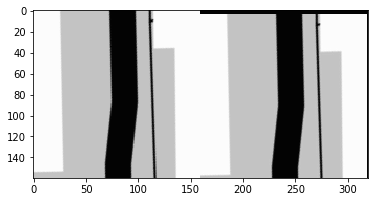

In [133]:
plt.imshow(np.hstack((DGPS_data,shifted_image)))

In [39]:
dx1,dy1,Mi=main_mi_reg(GPS_data,DGPS_data)

In [40]:
print(dx1,dy1,Mi)
Tdx=(dx1)*0.182648401826484
Tdy=(dy1)*0.17316017316017315


print(dx_gt.shape)

3.040777802342202 -7.031062021316135 0.605378709379855
(2093,)


In [41]:
print((Tdx),(Tdy))
 
print(dx_gt[P],dy_gt[P])

0.5553932059072515 -1.217499917111019
-2.7198931923211664 -0.7824687270748785


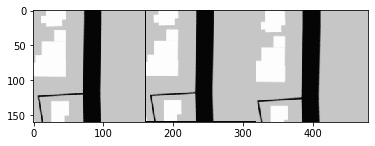

In [34]:
#shifted_image = shift(GPS_data,(-dx_gt, -dy_gt))
shifted_image = shift(DGPS_data,(Tdx, Tdy))
plt.imshow(np.hstack((DGPS_data,shifted_image,GPS_data)))

(2093,)


In [562]:
dx,dy,Mi=main_mi_reg(shifted_image,DGPS_data)

[-4.  4.]
2.875748020083555 2.4596513271973275 3.9874145202199753 0.5068422561737763
[12.88479 -4.75724]
3.3136903400781086 2.4350628440244417 5.3855331675165665 0.1278670736464312
[ 3.8382  11.56904]
3.23691037286104 2.5139754243931107 5.177080729818397 0.20114930121649632
[ -2.01124 -11.97974]
3.0085073057918565 2.4546344420030772 5.103592341882315 0.1323090735429797
[-4.74197  9.86197]
3.005701613903257 2.501867339485009 4.9591182881176765 0.2000011516903948
[ 3.0029  -9.45058]
3.27816507156742 2.4506916456933103 5.3922541660929895 0.11875657362039134
[9.92254 3.10807]
3.18494771624919 2.491468564109247 4.8107866897203655 0.3072934011575153
[-11.86756  -3.51901]
3.2759182542541003 2.430934321249192 5.046648736836998 0.23395099925146418
[-14.59156  13.69466]
3.0260778650502655 2.5634350245473914 5.310369637988245 0.10022496811478301
[  9.07228 -13.16833]
3.1649624821982885 2.4843571039017256 5.3989110590908815 0.08930130788377223
[0.04091 6.85457]
3.0449249045048674 2.468658368656157

3.178977547403181 2.4155267000102043 5.082152284990526 0.18489226916747742
[-9.34349 -1.69508]
3.3290263389365684 2.435151971185607 4.959811835945681 0.28250901479044355
[1.86116 0.74025]
3.3322876521083824 2.4252339419389033 4.896695420763203 0.3028080401909645
[-6.67288 -2.01165]
2.974654250305235 2.445415149657939 4.571477043590207 0.31463321593114396
[ 8.77977 10.40149]
3.265405842058965 2.5019888949291866 5.246989164866985 0.18206676114442097
[2.35173 9.06567]
3.1466124529827875 2.4905538431786693 4.926550681330105 0.25384297569535264
[ 12.06724 -12.31416]
3.2290017917689773 2.501197547851706 5.484432510395038 0.086479889559416
[-10.28091   0.74702]
3.246764448932529 2.4372567016843223 4.848170389114614 0.29713425002407945
[1.16324 7.52382]
3.2817024441320024 2.465376546997139 4.858448354500885 0.31241368652650026
[0.57397 8.5351 ]
3.3642301509548247 2.477651757382475 5.033431777948151 0.2800207752839985
[2.94405 3.48426]
3.3516173377838783 2.484065206481568 4.749526129065754 0.37

3.0612335678359686 2.4631479001901084 4.677095092421025 0.30855795289454596
[-6.4766   0.53504]
3.374292855640758 2.412503283860481 4.668689623141438 0.39188427385051366
[-3.53928 -0.27991]
3.3918812460644214 2.4159997934370523 4.709619292020253 0.38365166879564977
[-3.66896  2.62437]
3.381808925134627 2.4594030248132617 4.20947544514082 0.5657970062262934
[-1.66956  2.93642]
3.1451042802004134 2.506569412725207 4.010278960779699 0.5845957350103115
[-2.82195  3.66921]
3.290614445485181 2.4809664101418014 4.135318303694867 0.5726694940115208
[-6.09984 -4.65476]
3.319513419254216 2.4205958129779335 5.057840177110256 0.2406895975520756
[-2.91425  1.52799]
3.3276934589986267 2.4162328373090207 4.288491037439373 0.5132770475482403
[-9.11825  2.33798]
3.2889931506665784 2.4536036423148833 4.712177876139489 0.36272720937018776
[-4.85067  1.6602 ]
3.2555242439048833 2.432350148280706 4.35586865723851 0.47335021730362437
[-8.44888  0.15883]
3.2223755224006765 2.4176999227618055 4.72321236534996

[-4.15369  2.83128]
3.2058069771717155 2.470500649424924 4.10941539966564 0.5567727288161254
[-1.18448  2.10727]
3.2676454535690507 2.4413172461235506 4.300914331536909 0.49852621402306796
[-3.23411  3.77351]
3.2411497006511043 2.469993131411474 4.150610428181095 0.5515379150415641
[-1.09719  2.99331]
3.081632232008647 2.490169582201051 4.011268035686592 0.5633370403176691
[-3.23225  3.64532]
3.3216143007382035 2.4751804200957497 4.200102895643507 0.5568562142209097
[-2.06053  3.2356 ]
3.298583651012284 2.485858782135999 4.122043053674953 0.5805416599083165
[-5.03662  3.82641]
3.0850240561293942 2.4700668900311413 4.24837406639541 0.47336687807615246
[-5.64991  3.5957 ]
3.28148140656465 2.468578802703149 4.453264954374211 0.4556306604529872
[-4.57841  3.32606]
3.3299246304748924 2.467404491312016 4.324366570755272 0.5138712588688502
[-1.49469  2.95907]
3.170135994658226 2.49703004847672 4.043699494242546 0.5770221885184098
[-3.51998  3.89569]
3.1584568757097733 2.4743549838785066 4.133

[-3.03882  3.45418]
3.2942227554284833 2.4817361287965456 4.115803418838806 0.5806233223538315
[-1.35867  3.69219]
3.354090678453314 2.474919671369779 4.260863323830918 0.5442755497417386
[-2.60267  3.43   ]
3.4182661082151666 2.488465330379845 4.218548149361379 0.578829777840958
[-1.6275   2.78374]
3.3323285859726655 2.4769653878440314 4.201478764474706 0.5596316322528518
[-3.17263  3.20311]
3.2585467370329484 2.48817578928886 4.0801139586468045 0.5853034754797639
[-2.32163  2.85944]
3.2635068614176457 2.497480423777972 4.048149198802484 0.5999609717334289
[-3.22878  3.33446]
3.3401617037662454 2.4825815390607087 4.164073711187044 0.5760024890735901
[-2.37017  2.98903]
3.148431174835003 2.504908118927508 3.897920657592904 0.6250830210942335
[-1.99129  3.06651]
3.0367644343330484 2.497274039550353 3.8446270587948312 0.6134748609477121
[-3.60098  3.13951]
3.241525386555435 2.4923639196988616 4.10775295955178 0.5721060173703735
[-2.95418  3.20551]
3.183415145683913 2.490852584435832 3.94

3.4403988412744892 2.4684822844357384 4.221148979317615 0.5791407427503371
[-2.3166  2.8349]
3.2920937792851723 2.491082228595763 4.080537494124753 0.5945553920833965
[-2.53406  2.74446]
3.3589850686300977 2.4803604593424717 4.1343251112796455 0.5907016002982511
[-3.74179  2.75124]
3.2639314098220527 2.473959394309613 4.12922912121158 0.5661062138930392
[-2.69026  2.87144]
3.231236451933987 2.509504967825015 3.915848507301751 0.640853830970423
[-2.50778  3.04903]
3.2067572005085565 2.5077235277732335 3.9574288328069307 0.6196004467510555
[-2.50258  3.14319]
3.299854692293917 2.500727462719227 4.07028011334828 0.60233948086119
[-2.32825  2.73202]
3.356032820785917 2.475651675444551 4.159185058893182 0.5802405965424199
[-2.23042  3.31581]
3.3687142095402915 2.483495192380306 4.178901235651744 0.5785117504037413
[-3.40172  2.89736]
3.1999892424863554 2.5029843076064964 4.010527287569937 0.598014295025706
[-3.08542  3.07131]
3.1323210235144487 2.501068427186528 3.9231318270037816 0.6110343

[-2.85135  3.15377]
3.204878346364846 2.4988504543110928 3.943514170141655 0.6219990464748999
[-2.82839  3.10709]
3.1763416048745743 2.5054669250667443 3.889285576474564 0.6354140111900096
[-2.50139  2.86374]
3.2784445998579 2.5039496060373616 4.030732459372767 0.6113691625192631
[-3.09861  3.23137]
3.2768343379238174 2.4890615680071964 4.082557108379488 0.5894221748632688
[-2.64671  3.21205]
3.32889275091558 2.4991995117057777 4.099970281524299 0.5991340869561046
[-2.77415  3.21472]
3.28557151357963 2.4962248557847273 4.039575550060792 0.608353323952156
[-2.99318  3.09559]
3.065859783343585 2.499183760023988 3.8156391947849526 0.6319969208950683
[-2.80205  2.78789]
3.2585152035738085 2.490378792385605 3.9703257386071997 0.6243497707255999
[-3.13433  3.13154]
3.1986077690902457 2.4976245977843554 4.003259110422288 0.5989713123084083
[-2.82718  3.13508]
3.1968442893223967 2.5006660724137677 3.921978282885452 0.627971494945421
[-2.58722  2.8889 ]
3.245807982841906 2.5083908577006815 3.95

[-2.94626  2.90532]
3.0593529637181653 2.5102837679469094 3.761687201285987 0.6523942148203373
[-2.78736  2.86033]
3.189150231510317 2.5073159087161896 3.8724972533063435 0.6450233088085189
[-2.86199  2.94034]
3.002148404081673 2.5148084535326154 3.6453127407090844 0.6811687872035396
[-2.74254  2.94325]
3.090304123163141 2.514665840051184 3.6694201156746775 0.6943262883624259
[-2.57737  3.03211]
3.1731468539629826 2.510154806011488 3.888260326607329 0.636032216658384
[-2.63178  3.0404 ]
3.1758984054239994 2.5106929137463796 3.8707199635386917 0.6430651569006056
[-2.78835  2.94365]
3.0691234291859506 2.515831997280028 3.6483628922906446 0.6969317624512048
[-2.60683  3.0712 ]
3.2162209682369274 2.5085595885259373 3.941933090387491 0.6276666269388722
[-2.89541  2.91228]
3.0586125216599815 2.5118833458803613 3.7331425294831524 0.6628735931201771
[-2.99485  2.82457]
3.1299490096937004 2.497680994576199 3.855186243886365 0.633921305250204
[-2.68617  2.95712]
3.114387695765551 2.5142251898272

[-2.687    2.98298]
3.1022737767778152 2.5145950991357 3.703693907023994 0.6849842674258289
[-2.776    2.96694]
3.058134979318843 2.514297018265498 3.6093602815169143 0.7079450515982648
[-2.74994  2.98547]
3.073432274584744 2.515046431919539 3.627030725585881 0.7054917953231047
[-2.78067  2.94228]
3.0789711143720693 2.5156702468747087 3.652711421351209 0.6977565044001003
[-2.84802  2.9635 ]
3.0139314354952638 2.515903985890991 3.6310061031554133 0.6895602413084891
[-2.73297  2.99075]
3.080401230948711 2.5151440062346744 3.641374348984281 0.7020652334039374
[-2.75895  2.94221]
3.0926145544648422 2.5143166420692 3.6623304822450122 0.697360843448975
[-2.70981  2.99362]
3.0930290837309315 2.5143815359647834 3.672876972010579 0.6936952114943088
[-2.81078  2.95153]
3.0427997355686465 2.518771956858807 3.631820242111397 0.6970601676284337
[-2.78634  3.00692]
3.0350275959782334 2.5111706159555895 3.659826123465505 0.6832945066538824
[-2.78091  3.01222]
3.046543304579699 2.5110076402794914 3.67

3.0768023484116456 2.518002573895497 3.6133119700546388 0.711892877669927
[-2.75609  2.96175]
3.0767703820999874 2.5179479945901986 3.613329259595258 0.7118669857653542
[-2.75609  2.96175]
3.0767863810077816 2.5179752972752985 3.6133206294867355 0.7118799332279391
[-2.75609  2.96175]
3.0768182843322247 2.5180298244648847 3.613303281319409 0.7119058190925452
[-2.75609  2.96175]
3.0767703820999874 2.5179479945901986 3.613329259595258 0.7118669857653542
[-2.75609  2.96175]
3.0767703820999874 2.5179479945901986 3.613329259595258 0.7118669857653542
[-2.75609  2.96175]
3.0767703820999874 2.5179479945901986 3.613329259595258 0.7118669857653542
[-2.75609  2.96175]
3.0767543516675966 2.5179206658260944 3.613337860359744 0.7118540352809436
[-2.75609  2.96175]
3.0767863810077816 2.5179752972752985 3.6133206294867355 0.7118799332279391
[-2.75609  2.96175]
3.0767863810077816 2.5179752972752985 3.6133206294867355 0.7118799332279391
[-2.75609  2.96175]
3.0767863810077816 2.5179752972752985 3.61332062

[-2.75609  2.96175]
3.0768023484116456 2.518002573895497 3.6133119700546388 0.711892877669927
[-2.75609  2.96175]
3.0768023484116456 2.518002573895497 3.6133119700546388 0.711892877669927
[-2.75609  2.96175]
3.0767863810077816 2.5179752972752985 3.6133206294867355 0.7118799332279391
[-2.75609  2.96175]
3.076865903400412 2.5181114200089354 3.613277039499027 0.7119446252564552
[-2.75609  2.96175]
3.0768974924070527 2.5181656870420976 3.613259398810289 0.7119704809580324
[-2.75609  2.96175]
3.0768023484116456 2.518002573895497 3.6133119700546388 0.711892877669927
[-2.75609  2.96175]
3.0768023484116456 2.518002573895497 3.6133119700546388 0.711892877669927
[-2.75609  2.96175]
3.076865903400412 2.5181114200089354 3.613277039499027 0.7119446252564552
[-2.75609  2.96175]
3.0767863810077816 2.5179752972752985 3.6133206294867355 0.7118799332279391
[-2.75609  2.96175]
3.0767543516675966 2.5179206658260944 3.613337860359744 0.7118540352809436
[-2.75609  2.96175]
3.0768974924070527 2.5181656870420